/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode: 1 | Reward: 8
Episode: 2 | Reward: 41
Episode: 3 | Reward: 49
Episode: 4 | Reward: 40
Episode: 5 | Reward: 24
Episode: 6 | Reward: 26
Episode: 7 | Reward: 11
Episode: 8 | Reward: 12
Episode: 9 | Reward: 11
Episode: 10 | Reward: 10
Episode: 11 | Reward: 8
Episode: 12 | Reward: 9
Episode: 13 | Reward: 10
Episode: 14 | Reward: 10
Episode: 15 | Reward: 9
Episode: 16 | Reward: 10
Episode: 17 | Reward: 9
Episode: 18 | Reward: 10
Episode: 19 | Reward: 10
Episode: 20 | Reward: 10
Episode: 1 | Reward: 24
Episode: 2 | Reward: 12
Episode: 3 | Reward: 30
Episode: 4 | Reward: 20
Episode: 5 | Reward: 10
Episode: 6 | Reward: 15
Episode: 7 | Reward: 12
Episode: 8 | Reward: 14
Episode: 9 | Reward: 18
Episode: 10 | Reward: 13
Episode: 11 | Reward: 12
Episode: 12 | Reward: 11
Episode: 13 | Reward: 9
Episode: 14 | Reward: 9
Episode: 15 | Reward: 9
Episode: 16 | Reward: 11
Episode: 17 | Reward: 10
Episode: 18 | Reward: 9
Episode: 19 | Reward: 10
Episode: 20 | Reward: 11
Episode: 1 | Reward: 20
Epi

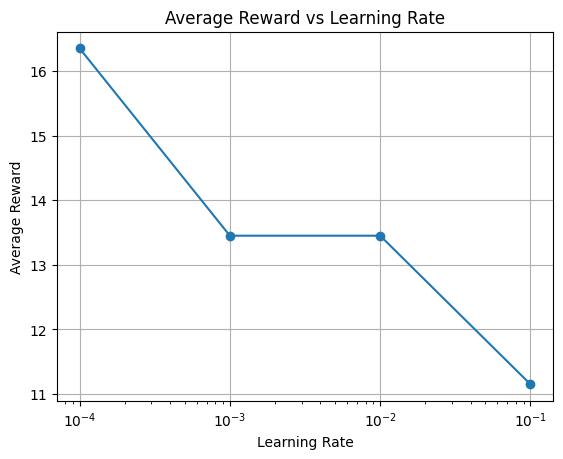

In [2]:
# -*- coding: utf-8 -*-
"""Untitled1.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1NU03ZewrDUoJ_KkBdZEkrMXRZEN37KdW
"""

import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import AdamW
import gym
import itertools
from matplotlib import pyplot as plt


def argmax(x):
    ''' Own variant of np.argmax with random tie breaking, function of assignment 1  '''
    try:
        return np.random.choice(np.where(x == np.max(x))[0])
    except:
        return np.argmax(x)


def softmax(x, temp):
    ''' Computes the softmax of vector x with temperature parameter 'temp', function of assignment 1 '''
    x = x / temp  # scale by temperature
    z = x - max(x)  # substract max to prevent overflow of softmax
    return np.exp(z) / np.sum(np.exp(z))  # compute softmax


class DQAgent:
    def __init__(self, state_size, action_size, replay_memory_capacity=1000, epsilon=0.5, target=True, replay=True,learning_rate=0.01):
        self.state_size = state_size  # Set output size for Q-function
        self.action_size = action_size  # Set input size for Q-function
        self.memory = deque(maxlen=replay_memory_capacity)  # Initialize replay memory to capacity N
        self.gamma = 0.95  # Future rewards are discounted by gamma per time-step
        self.learning_rate = learning_rate  # Learning rate for gradient descent
        self.Q_network = self._build_model()  # Initialize action-value function Q with random weights
        self.Q_network_target = self._build_model()
        self.epsilon = epsilon  # Probability for random action
        self.epsilon_min = 0.01
        self.episodes_max = 10
        self.target = target  # If True predictions are made using an alternate network that undergoes periodic updates
        self.use_replay = replay # If True experience replay will be used

    def _build_model(self):  # Takes state as input, outputs Q values for legal actions
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=AdamW(learning_rate=self.learning_rate), metrics=['accuracy'])
        return model

    def store_transition(self, s, a, r, s_next, done):  # Stores transition in replay memory
        self.memory.append((s, a, r, s_next, done))

    def Q_value_predict(self, s):
        if self.target:
            return self.Q_network_target.predict(s, verbose=0)
        else:
            return self.Q_network.predict(s, verbose=0)

    def replay(self, batch_size):
        if self.use_replay:
            minibatch = random.sample(self.memory, batch_size)  # if experience replay is used experiences are randomly sampled from memory
        else:
            index = len(self.memory) - batch_size
            minibatch = list(itertools.islice(self.memory, index, None))  # if experience replay is not used the model is trained on the last experiences

        for s, a, r, s_next, done in minibatch:
            if done:
                y = r
            else:
                Q_next = np.amax(self.Q_value_predict(s_next)[0])
                y = r + self.gamma * Q_next
            Q = self.Q_value_predict(s)
            Q[0][a] = y
            self.Q_network.fit(s, Q, verbose=0)  # Keras builds the loss function akin to equation 3 as outlined in the DQN paper.

    def select_action(self, s, current_episode, method="anneal_epsilon"):
        random_action = env.action_space.sample() # Random action
        Q_values = self.Q_network.predict(s, verbose=0)  # Get Q-values from Q-function
        greedy_action = np.argmax(Q_values[0])  # action associated with the maximum Q-value
        if method == "egreedy":
            if self.epsilon >= np.random.rand():
                return random_action
            else:
                return greedy_action
        elif method == "anneal_epsilon":
            self.linear_annealing_epsilon(current_episode)
            if self.epsilon >= np.random.rand():
                return random_action
            else:
                return greedy_action
        elif method == "boltzmann":
            return argmax(softmax(Q_values, self.epsilon))

    def update_target_network(self):
        self.Q_network_target.set_weights(self.Q_network.get_weights())

    def linear_annealing_epsilon(self, current_episode):
        """Linear function decay of epsilon parameter """
        gradient_epsilon = (self.epsilon_min - 1.0) / self.episodes_max
        self.epsilon = gradient_epsilon * current_episode + 1.0


if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    episodes = 20
    batch_size = 16
    rewards = []

    learning_rates = [0.0001, 0.001, 0.01, 0.1]  # Define a range of learning rates to search over

    best_learning_rate = None
    best_reward = float('-inf')

    for lr in learning_rates:
        agent = DQAgent(state_size, action_size, replay=False, learning_rate=lr)  # Initialize agent with current learning rate
        episode_rewards = []

        for e in range(episodes):
            s = env.reset()
            s = np.array([s]).reshape([1, state_size])
            done = False
            time = 0
            while not done and time < 500:  # Corrected the condition for episode termination
                a = agent.select_action(s, e, "anneal_epsilon")
                step_result = env.step(a)
                s_next, r, done, _ = step_result[:4]
                s_next = np.reshape(s_next, [1, state_size])
                agent.store_transition(s, a, r, s_next, done)

                if len(agent.memory) >= batch_size:
                    agent.replay(batch_size)

                s = s_next
                time += 1
                if time % 10 == 0 and agent.target:
                    agent.update_target_network()

            episode_rewards.append(time)
            print("Episode:", e+1, "| Reward:", time)

        avg_reward = np.mean(episode_rewards)
        rewards.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            best_learning_rate = lr

    print("Best learning rate:", best_learning_rate)
    print("Best average reward:", best_reward)

    # Plotting rewards for each learning rate
    plt.plot(learning_rates, rewards, marker='o')
    plt.xscale('log')  # Using logarithmic scale for better visualization
    plt.title("Average Reward vs Learning Rate")
    plt.xlabel("Learning Rate")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.show()

    env.close()

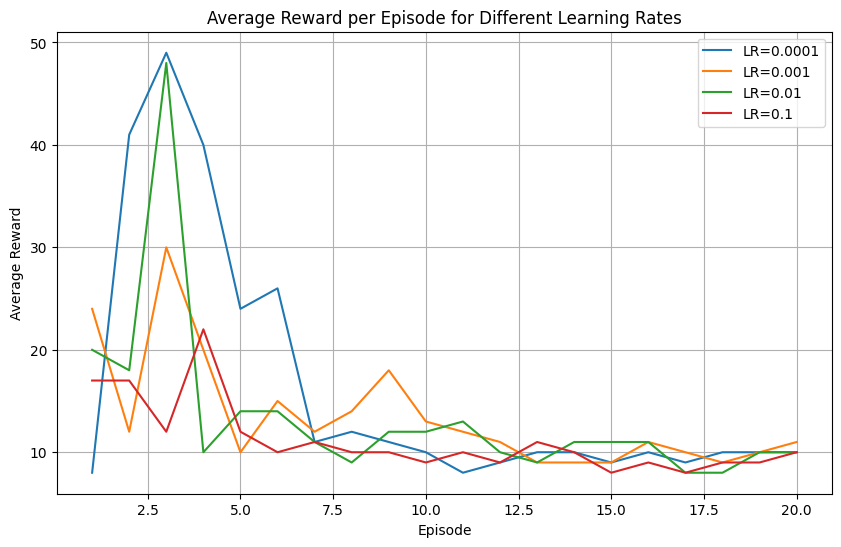

In [3]:
import matplotlib.pyplot as plt

# Rewards per episode for each learning rate
rewards_lr_001 = [8, 41, 49, 40, 24, 26, 11, 12, 11, 10, 8, 9, 10, 10, 9, 10, 9, 10, 10, 10]
rewards_lr_01 = [24, 12, 30, 20, 10, 15, 12, 14, 18, 13, 12, 11, 9, 9, 9, 11, 10, 9, 10, 11]
rewards_lr_1 = [20, 18, 48, 10, 14, 14, 11, 9, 12, 12, 13, 10, 9, 11, 11, 11, 8, 8, 10, 10]
rewards_lr_10 = [17, 17, 12, 22, 12, 10, 11, 10, 10, 9, 10, 9, 11, 10, 8, 9, 8, 9, 9, 10]

# Plotting rewards for each learning rate
plt.figure(figsize=(10, 6))

# Learning rate 0.001
plt.plot(range(1, len(rewards_lr_001) + 1), rewards_lr_001, label='LR=0.0001')

# Learning rate 0.01
plt.plot(range(1, len(rewards_lr_01) + 1), rewards_lr_01, label='LR=0.001')

# Learning rate 0.1
plt.plot(range(1, len(rewards_lr_1) + 1), rewards_lr_1, label='LR=0.01')

# Learning rate 1
plt.plot(range(1, len(rewards_lr_10) + 1), rewards_lr_10, label='LR=0.1')

plt.title("Average Reward per Episode for Different Learning Rates")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()
